In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

In [2]:
df = pd.read_csv('datasets/sales_data.csv', encoding='latin1')
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [3]:
df.columns

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID',
       'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE',
       'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE',
       'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')

In [4]:
df.describe()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP
count,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.00000,2823.000000
mean,10258.725115,35.092809,83.658544,6.466171,3553.889072,2.717676,7.092455,2003.81509,100.715551
std,92.085478,9.741443,20.174277,4.225841,1841.865106,1.203878,3.656633,0.69967,40.187912
min,10100.000000,6.000000,26.880000,1.000000,482.130000,1.000000,1.000000,2003.00000,33.000000
25%,10180.000000,27.000000,68.860000,3.000000,2203.430000,2.000000,4.000000,2003.00000,68.000000
50%,10262.000000,35.000000,95.700000,6.000000,3184.800000,3.000000,8.000000,2004.00000,99.000000
75%,10333.500000,43.000000,100.000000,9.000000,4508.000000,4.000000,11.000000,2004.00000,124.000000
max,10425.000000,97.000000,100.000000,18.000000,14082.800000,4.000000,12.000000,2005.00000,214.000000


## Building an RFM (Recency, Frequency, Monetary) Table

To get started with customer segmentation, we need to build an RFM model which will provide us with key metrics to do this. The method for calculating these metrics are,

Recency = SnapshotDate - InvoiceDate, where SnapshotDate is a custom field we will create

Frequency = count of transactions per customer

Monetary = sum of all transactions per customer

In [5]:
# Format ORDERDATE to a date format
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')

# Create a snapshot date variable by taking the max date and adding one day
snapshot_date = max(df['ORDERDATE']) + datetime.timedelta(days=1)

# Create a TRANSACTIONS column
df['TRANSACTIONS'] = df['QUANTITYORDERED'] * df['PRICEEACH']

# Aggregate data by each customer
customers = df.groupby(['CUSTOMERNAME']).agg({
    'ORDERDATE': lambda x: (snapshot_date - x.max()).days,
    'ORDERNUMBER': 'count',
    'TRANSACTIONS': 'sum'
})

# Rename columns
customers.rename(columns = {
    'ORDERDATE': 'Recency',
    'ORDERNUMBER': 'Frequency',
    'TRANSACTIONS': 'Monetary'
}, inplace=True)

customers.head()

,Recency,Frequency,Monetary
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,136873.25
Alpha Cognac,65,20,58885.28
Amica Models & Co.,265,26,72645.01
"Anna's Decorations, Ltd",84,46,121260.41
Atelier graphique,188,7,21213.16


We now have an RFM table. Before we carry out our segmentation we need to ensure the data is normalised.

## Managing Skewness and Scaling

To show the data is not skewed, we make the assumption that the variables have the same mean and variance.

We can start to test this assumption by plotting histograms for each variable.

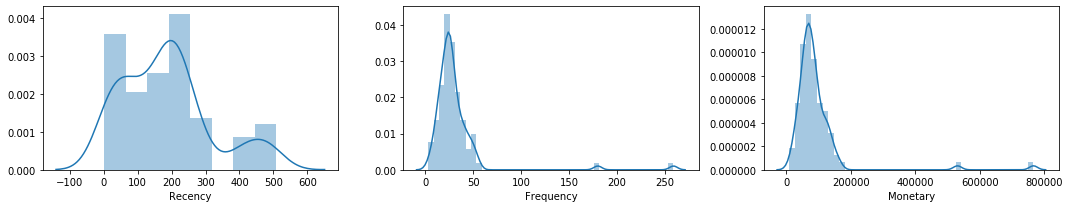

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

sns.distplot(customers['Recency'], ax=ax[0])
sns.distplot(customers['Frequency'], ax=ax[1])
sns.distplot(customers['Monetary'], ax=ax[2])

plt.tight_layout()
plt.show()

As we can see the data is skewed so we need to transform the data so it has a more symmetrical form.

Using the following methods we can transform the data.

Log transformation

Square root transformation

Box-cox transformation

In [7]:
from scipy import stats

def analyse_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    
    sns.distplot(customers[x], ax=ax[0,0])
    sns.distplot(np.log(customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(customers[x])[0], ax=ax[1,1])
    
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

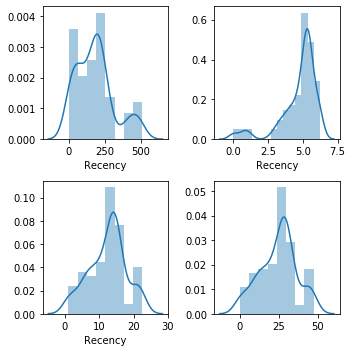

0.78
-1.92
-0.25
-0.2


In [8]:
analyse_skewness('Recency')

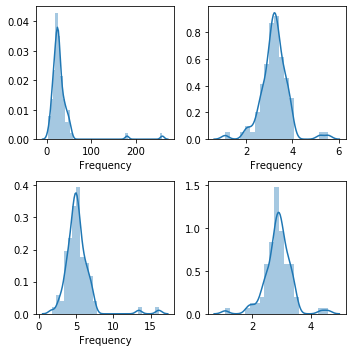

5.75
0.32
3.28
-0.06


In [9]:
analyse_skewness('Frequency')

As we can see from the analysis, the box-cox transformation shows the most symmetrical form compared to the other methods.

In addition to eyeballing the chart we can see from the skewness figures, the box-cox method gives us figures closest to zero, with Recency being -0.2 and Frequency -0.06.

A quick disclaimer, we can only use transformation for positive values. As Monetary could be subject to negative figures, we need to run a check.

In [10]:
df['TRANSACTIONS'].values

sum(n < 0 for n in df['TRANSACTIONS'].values)

0

We do not have any negative values so we can carry out our transformation on Monetary.

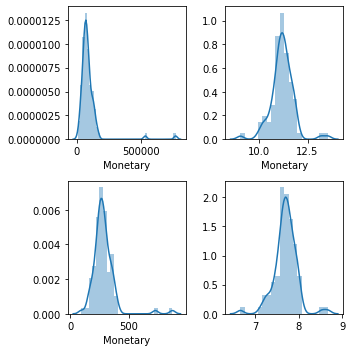

5.77
0.33
3.3
-0.06


In [11]:
analyse_skewness('Monetary')

Again, after analysis, it seems the box-cox method gives us the best results.

Given our results, we can now transform our data with the following.

In [12]:
from scipy import stats

customers_transformed = pd.DataFrame()

customers_transformed['Recency'] = stats.boxcox(customers['Recency'])[0]
customers_transformed['Frequency'] = stats.boxcox(customers['Frequency'])[0]
customers_transformed['Monetary'] = stats.boxcox(customers['Monetary'])[0]

customers_transformed.head()

,Recency,Frequency,Monetary
0,28.029034,3.441354,7.974871
1,14.943876,2.705023,7.602375
2,33.118162,2.916242,7.697230
3,17.351154,3.362513,7.922758
4,27.386614,1.820324,7.120299


In [13]:
customers_transformed.tail()

,Recency,Frequency,Monetary
87,33.800028,3.055709,7.808625
88,28.969528,2.884911,7.664287
89,27.869627,2.663277,7.598407
90,46.272701,2.349771,7.441190
91,29.277211,2.916242,7.700458


Although we have transformed the data so it is less skewed we can still not use the data yet. If we look at the plot once more, each variable doesn't have the same mean and variance. We have to normalize the data.

In [14]:
from sklearn.preprocessing import StandardScaler

# Initialise the object
scaler = StandardScaler()

# Fit and transform the data
scaler.fit(customers_transformed)
customers_norm = scaler.transform(customers_transformed)

# Test if the dataset has mean 0 and variance 1
print(customers_norm.mean(axis=0).round(2))
print(customers_norm.std(axis=0).round(2))

[-0.  0.  0.]
[1. 1. 1.]


We can see that our normalised dataset has a mean of zero and variance 1.

Below is our finalised RFM dataset, now we can start our segmentation analysis.

In [15]:
pd.DataFrame(customers_norm).head()

,0,1,2
0,0.287960,1.218717,1.070641
1,-0.825875,-0.376181,-0.369502
2,0.721157,0.081322,-0.002776
3,-0.620963,1.047948,0.869162
4,0.233276,-2.292444,-2.233306


## Segmentation Analysis

Now we have normalised the data we can use the k-means algorithm to carry out our segmentation.

To determine our k, we can use the elbow method.

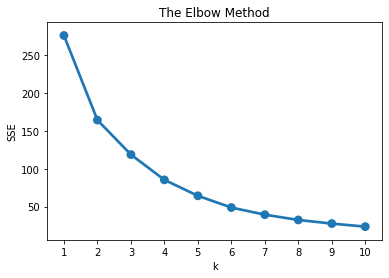

In [18]:
from sklearn.cluster import KMeans

# Sum of squares
sse = {}

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_norm)
    
    # SSE to the closest cluster centroid
    sse[k] = kmeans.inertia_
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Based on our line chart, I think k=4 is the most suitable fit.

In [20]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_norm)
model.labels_.shape

(92,)

## Interpret the Results

We can summarise the RFM table based on clusters and calculate the mean of each variable.

In [22]:
customers['Cluster'] = model.labels_

customers.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)

Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0        310.07     11.60   33739.61    15
1          2.00    219.50  648391.12     2
2         80.19     35.19  103733.40    36
3        237.90     24.18   70605.33    39

We can analyse the segments using the snake plot.

In [24]:
# Create the dataframe
df_norm = pd.DataFrame(customers_norm, columns=['Recency', 'Frequency', 'Monetary'])

df_norm['ID'] = customers.index
df_norm['Cluster'] = model.labels_

# Melt the data
df_norm_melt = pd.melt(df_norm.reset_index(),
                      id_vars = ['ID', 'Cluster'],
                      value_vars = ['Recency', 'Frequency', 'Monetary'],
                      var_name='Attribute',
                      value_name='Value')

df_norm_melt.head()

,ID,Cluster,Attribute,Value
0,"AV Stores, Co.",2,Recency,0.287960
1,Alpha Cognac,2,Recency,-0.825875
2,Amica Models & Co.,3,Recency,0.721157
3,"Anna's Decorations, Ltd",2,Recency,-0.620963
4,Atelier graphique,0,Recency,0.233276


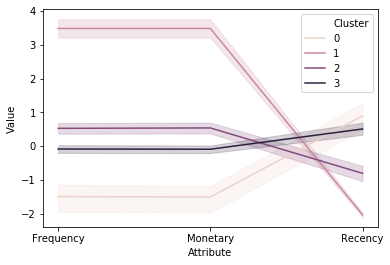

In [25]:
# Visualise the data
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_norm_melt)
plt.show()

We can interpret these clusters as follows,

Cluster 0 - these customers have not purchased very frequently, they have spent a low monetary value and their recency is high. This suggest that cluster 0 could be churned customers.

Cluster 1 - these customers purchased very frequently, spend a high amount and purchased very recently. This suggests these customers are loyal and returning customers.

Cluster 2 - these customers their frequency, monetary spend and recency is in the middle of cluster 0 and 1, this suggest these customers are not quite loyal customers however, they are not totally churned. The still purchase products but perhaps not as much as the customers in cluster 1.

Cluster 3 - these customers follow a similar pattern to cluster 2 but with a higher recency.

The fact that cluster 2 and 3 are similar suggest we could model the data using k=3.